In [ ]:
# Cell 1: Download and preprocess CIFAR-10 and PCam datasets for ResNet34 (224x224)

import torch, gc
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import os, random
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing



In [2]:
#For reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4,5,6,7"

# Loop through all available GPUs
for gpu_id in range(torch.cuda.device_count()):
    torch.cuda.set_device(gpu_id)  # Set the current GPU
    torch.cuda.empty_cache()  
    torch.cuda.ipc_collect()
     # Clear the cache for this GPU
    gc.collect()                   # Trigger garbage collection

print("All GPU memory has been cleared.")


In [3]:
# ImageNet normalization stats for ResNet34 pretrained weights [6][9]
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

workers = multiprocessing.cpu_count()
print(f"Number of CPU cores available: {workers}")
# Set the number of workers for DataLoader

# Common transform: resize to 224x224, convert to tensor, normalize
common_train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
common_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# CIFAR-10 download and preprocessing
cifar10_train = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=common_train_transform
)
cifar10_test = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=common_test_transform
)

# PCam download and preprocessing [1][2][7]
pcam_train = datasets.PCAM(
    root='./data',
    split='train',
    download=True,
    transform=common_train_transform
)
pcam_val = datasets.PCAM(
    root='./data',
    split='val',
    download=True,
    transform=common_test_transform
)
pcam_test = datasets.PCAM(
    root='./data',
    split='test',
    download=True,
    transform=common_test_transform
)

# Example DataLoader setup (adjust batch_size as needed)
batch_size = 712
cifar10_train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
cifar10_test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)

pcam_train_loader = DataLoader(pcam_train, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
pcam_val_loader = DataLoader(pcam_val, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)
pcam_test_loader = DataLoader(pcam_test, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)

print("CIFAR-10 and PCam datasets are downloaded and preprocessed to 224x224 for ResNet34.")


Number of CPU cores available: 112
CIFAR-10 and PCam datasets are downloaded and preprocessed to 224x224 for ResNet34.


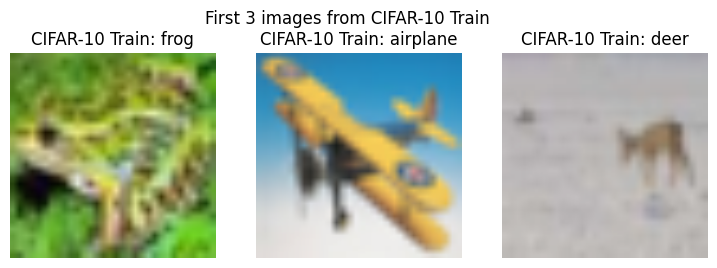

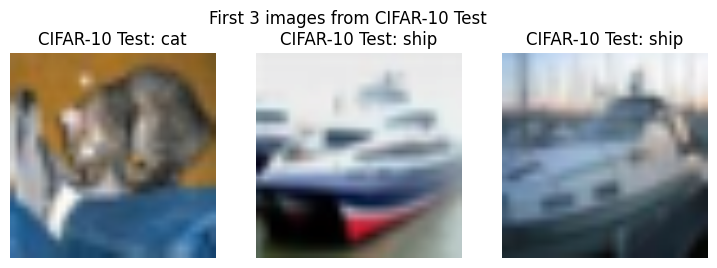

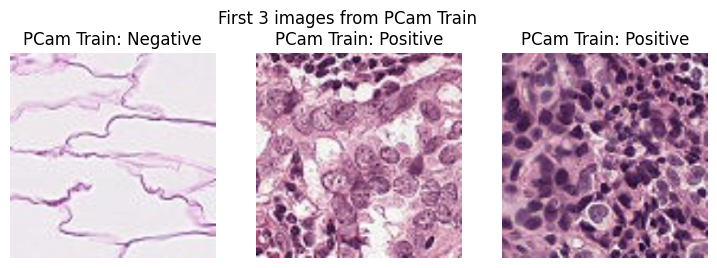

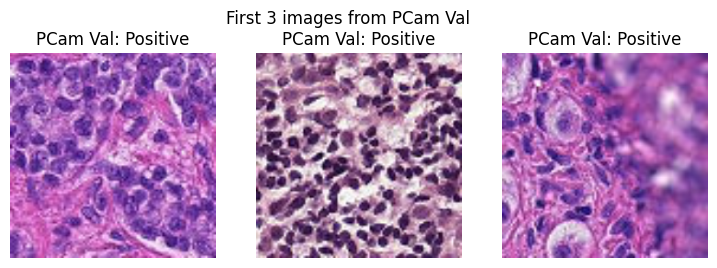

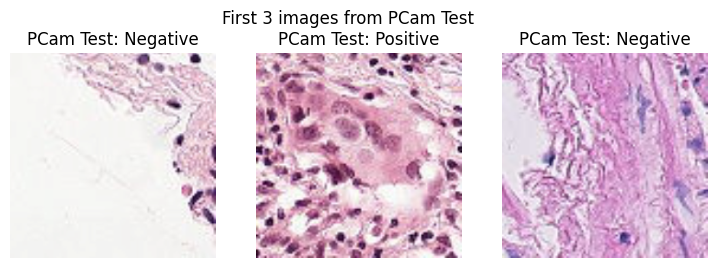

In [4]:
# Helper function to denormalize and show an image
def imshow(img, mean=IMAGENET_MEAN, std=IMAGENET_STD, title=None):
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Function to show first 3 images from a DataLoader
def show_first_n_images(dataloader, class_names, dataset_name, n=3):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    plt.figure(figsize=(n * 3, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        imshow(images[i])
        if class_names is not None:
            plt.title(f"{dataset_name}: {class_names[labels[i]]}")
        else:
            plt.title(f"{dataset_name}: Label {labels[i].item()}")
    plt.suptitle(f"First {n} images from {dataset_name}")
    plt.show()

# Class names for CIFAR-10 and PCam
cifar10_classes = cifar10_train.classes
pcam_classes = ['Negative', 'Positive']

# Show images from each DataLoader
show_first_n_images(cifar10_train_loader, cifar10_classes, "CIFAR-10 Train")
show_first_n_images(cifar10_test_loader, cifar10_classes, "CIFAR-10 Test")
show_first_n_images(pcam_train_loader, pcam_classes, "PCam Train")
show_first_n_images(pcam_val_loader, pcam_classes, "PCam Val")
show_first_n_images(pcam_test_loader, pcam_classes, "PCam Test")


In [4]:
# Initialize ResNet34 model for CIFAR-10 and PCam
def initialize_resnet34(num_classes, device=None):
    """
    Initializes a ResNet34 model with a specified number of output classes.

    Args:
        num_classes (int): Number of output classes for the classification task.
        device (torch.device, optional): The device to load the model onto. Defaults to CUDA if available.

    Returns:
        torch.nn.Module: The initialized ResNet34 model.
    """
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    
    print(f"Initialized ResNet34 for {num_classes} classes on {device} (DataParallel={torch.cuda.device_count() > 1})")
    return model.to(device)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize models for CIFAR-10 and PCam
cifar_model = initialize_resnet34(num_classes=10, device=device)
pcam_model = initialize_resnet34(num_classes=2, device=device)


Initialized ResNet34 for 10 classes on cuda:0 (DataParallel=True)
Initialized ResNet34 for 2 classes on cuda:0 (DataParallel=True)


In [11]:
torch.save(cifar_model.state_dict(), 'cifar_model.pth')
torch.save(pcam_model.state_dict(), 'pcam_model.pth')


In [5]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader
from skactiveml.pool import UncertaintySampling
from skactiveml.utils import MISSING_LABEL

# Helper: PyTorch model wrapper for scikit-activeml
class TorchWrapper:
    def __init__(self, model, device):
        self.model = model
        self.device = device
    
    def fit(self, train_loader, epochs=5):
        self.model.train()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        criterion = torch.nn.CrossEntropyLoss()
        for epoch in range(epochs):
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
    
    def predict_proba(self, data_loader):
        self.model.eval()
        all_probs = []
        with torch.no_grad():
            for images, _ in data_loader:
                images = images.to(self.device)
                outputs = self.model(images)
                probs = F.softmax(outputs, dim=1)
                all_probs.append(probs.cpu().numpy())
        return np.concatenate(all_probs, axis=0)

# Active learning parameters
INIT_SIZE = 50
QUERY_SIZE = 5
N_CYCLES = 5

# Example for CIFAR-10
dataset = cifar10_train
model = cifar_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wrapper = TorchWrapper(model, device)

# 1. Split indices
all_indices = np.arange(len(dataset))
np.random.seed(42)
labeled_indices = np.random.choice(all_indices, size=INIT_SIZE, replace=False)
unlabeled_indices = np.setdiff1d(all_indices, labeled_indices)

# 2. Prepare label array for scikit-activeml
y = np.full(len(dataset), MISSING_LABEL)
y[labeled_indices] = [dataset[i][1] for i in labeled_indices]

# 3. Active learning loop
for cycle in range(N_CYCLES):
    print(f"\nAL Cycle {cycle+1}/{N_CYCLES} | Labeled: {len(labeled_indices)} | Unlabeled: {len(unlabeled_indices)}")

    # --- Training ---
    train_subset = Subset(dataset, labeled_indices)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
    wrapper.fit(train_loader, epochs=5)

    # --- Uncertainty Sampling ---
    unlabeled_subset = Subset(dataset, unlabeled_indices)
    unlabeled_loader = DataLoader(unlabeled_subset, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)
    probs = wrapper.predict_proba(unlabeled_loader)
    entropy = -np.sum(probs * np.log(probs + 1e-8), axis=1)
    query_indices = np.argsort(-entropy)[:QUERY_SIZE]
    newly_selected = unlabeled_indices[query_indices]

    # --- Update pools ---
    labeled_indices = np.concatenate([labeled_indices, newly_selected])
    unlabeled_indices = np.setdiff1d(unlabeled_indices, newly_selected)
    y[newly_selected] = [dataset[i][1] for i in newly_selected]

    # (Optional) Track selected samples, compute XAI, evaluate, etc.

    if len(unlabeled_indices) == 0:
        print("Unlabeled pool exhausted.")
        break

print("Active learning completed.")



AL Cycle 1/5 | Labeled: 50 | Unlabeled: 49950

AL Cycle 2/5 | Labeled: 55 | Unlabeled: 49945

AL Cycle 3/5 | Labeled: 60 | Unlabeled: 49940

AL Cycle 4/5 | Labeled: 65 | Unlabeled: 49935

AL Cycle 5/5 | Labeled: 70 | Unlabeled: 49930
Active learning completed.


In [6]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

def evaluate_model(model, dataloader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]
            preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {acc:.4f}")

    # Per-class accuracy
    if class_names is None:
        num_classes = np.max(all_labels) + 1
        class_names = [f"Class {i}" for i in range(num_classes)]
    per_class_acc = []
    for i, name in enumerate(class_names):
        mask = all_labels == i
        if np.sum(mask) > 0:
            acc_i = accuracy_score(all_labels[mask], all_preds[mask])
            per_class_acc.append(acc_i)
            print(f"Accuracy for {name}: {acc_i:.4f} ({np.sum(mask)} samples)")
        else:
            print(f"Accuracy for {name}: N/A (0 samples)")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return {
        "accuracy": acc,
        "per_class_accuracy": per_class_acc,
        "confusion_matrix": cm,
        "classification_report": classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    }

# Example usage:
# For CIFAR-10
cifar_class_names = cifar10_train.classes
cifar_results = evaluate_model(cifar_model, cifar10_test_loader, device, class_names=cifar_class_names)

# For PCam
#pcam_class_names = ['Negative', 'Positive']
#pcam_results = evaluate_model(pcam_model, pcam_test_loader, device, class_names=pcam_class_names)


Accuracy: 0.3304
Accuracy for airplane: 0.9490 (1000 samples)
Accuracy for automobile: 0.1790 (1000 samples)
Accuracy for bird: 0.0140 (1000 samples)
Accuracy for cat: 0.0450 (1000 samples)
Accuracy for deer: 0.7630 (1000 samples)
Accuracy for dog: 0.2590 (1000 samples)
Accuracy for frog: 0.8470 (1000 samples)
Accuracy for horse: 0.1710 (1000 samples)
Accuracy for ship: 0.0750 (1000 samples)
Accuracy for truck: 0.0020 (1000 samples)

Confusion Matrix:
[[949   4   0   5  14   0  22   1   5   0]
 [757 179   0   0  16   0  30  17   1   0]
 [340  49  14  10 262  13 298   8   6   0]
 [230  82   5  45 107  61 405  50  15   0]
 [ 96   5   9   4 763   4  96  17   6   0]
 [148 124   2  28 123 259 259  49   7   1]
 [ 30   4  12   1 104   1 847   1   0   0]
 [204  30   1   3 504  15  66 171   6   0]
 [869   3   0   0  30   0  21   2  75   0]
 [717 151   0   0  68   0  12  27  23   2]]

Classification Report:
              precision    recall  f1-score   support

    airplane       0.22      0.95 

In [22]:
import matplotlib
print(matplotlib.__version__)
print(matplotlib.__file__)
import os
import matplotlib
print(os.path.dirname(matplotlib.__file__))



3.10.3
/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/matplotlib/__init__.py
/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/matplotlib


In [21]:
!pip uninstall matplotlib

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code
  File "/tmp/ipykernel_697/2600834011.py", line 1, in <module>
    get_ipython().system('pip uninstall matplotlib')
  File "/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 657, in system_piped
  File "/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/IPython/utils/_process_posix.py", line 125, in system
ModuleNotFoundError: No module named 'pexpect'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/pygments/styles/__init__.py", line 45, in get_style_by_name
ModuleNotFoundError: No module named 'pygments.styles.default'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/miniconda3/envs/thesis/lib/python3

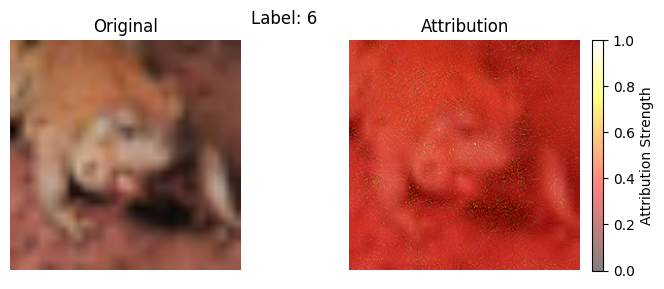

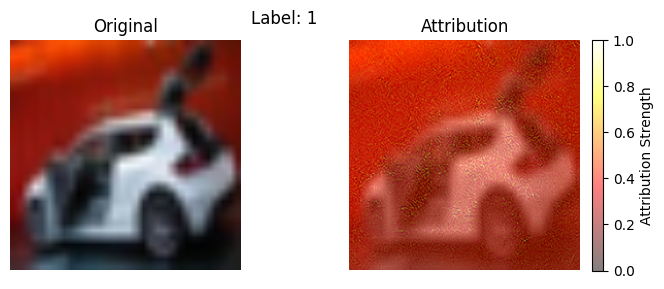

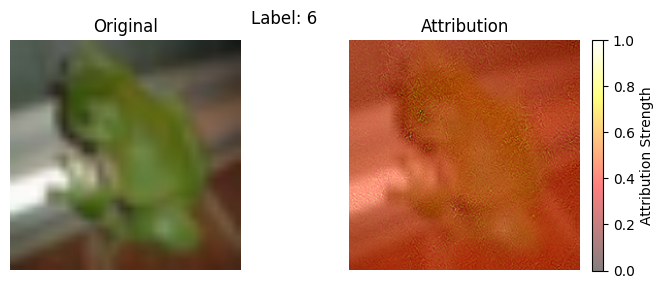

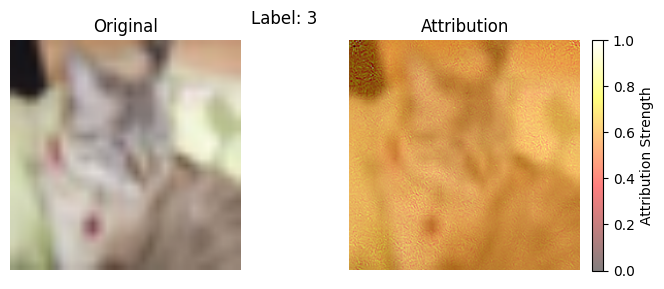

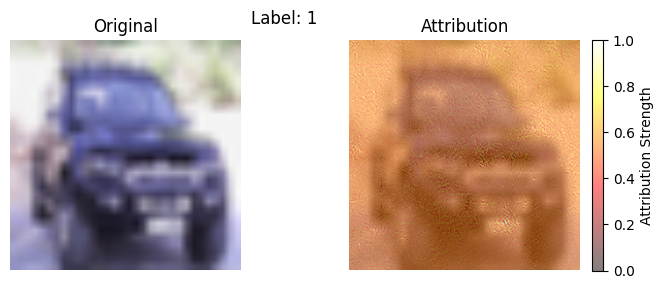

In [13]:
import torch
from captum.attr import GradientShap
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 1. Unwrap DataParallel model if needed
model_for_xai = cifar_model.module if isinstance(cifar_model, torch.nn.DataParallel) else cifar_model
model_for_xai.eval()

# 2. Select 5 test images and their labels
dataiter = iter(cifar10_test_loader)
images, labels = next(dataiter)
images, labels = images[5:10], labels[5:10]
images = images.to(device)
labels = labels.to(device)

# 3. Select baselines for GradientShap (e.g., 10 random images from test set)
# GradientShap works best with multiple baselines
dataiter = iter(cifar10_test_loader)
baseline_batch, _ = next(dataiter)
num_baselines = 10
if baseline_batch.shape[0] < num_baselines:
    # If batch smaller than 10, repeat as needed
    repeats = (num_baselines // baseline_batch.shape[0]) + 1
    baseline_batch = baseline_batch.repeat(repeats, 1, 1, 1)
baselines = baseline_batch[:num_baselines].to(device)

# 4. Initialize GradientShap
gs = GradientShap(model_for_xai)

# 5. Compute attributions
# For GradientShap, you can pass multiple baselines and the method will average over them
attributions = gs.attribute(images, baselines=baselines, target=labels, n_samples=50, stdevs=0.0)

# 6. Visualize attributions for each image
def show_attribution(img, attr, title=""):
    img = img.cpu().numpy().transpose(1,2,0)
    img = img * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
    img = np.clip(img, 0, 1)
    attr = attr.cpu().detach().numpy().sum(axis=0)
    attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
    fig, axs = plt.subplots(1, 2, figsize=(8,3))
    axs[0].imshow(img)
    axs[0].set_title("Original")
    axs[0].axis('off')
    im = axs[1].imshow(img)
    heatmap = axs[1].imshow(attr, cmap='hot', alpha=0.5)
    axs[1].set_title("Attribution")
    axs[1].axis('off')
    # Add colorbar for the heatmap
    plt.colorbar(heatmap, ax=axs[1], fraction=0.046, pad=0.04, label='Attribution Strength')
    plt.suptitle(title)
    plt.show()


for i in range(5):
    show_attribution(images[i], attributions[i], title=f"Label: {labels[i].item()}")


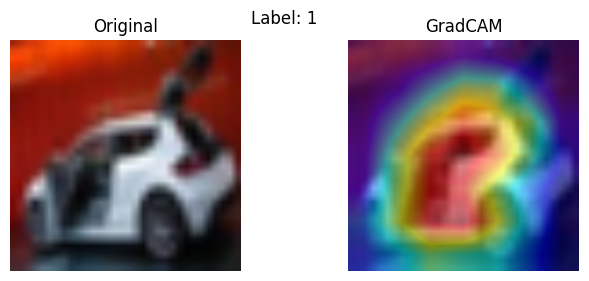

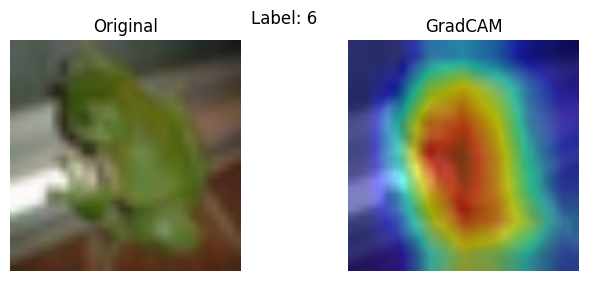

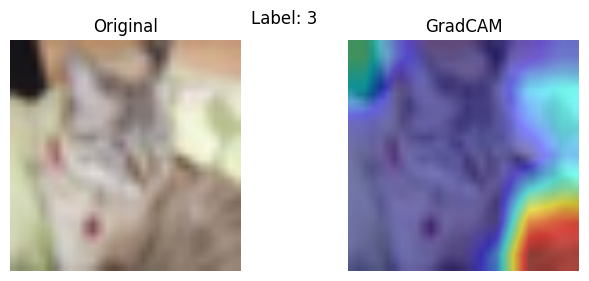

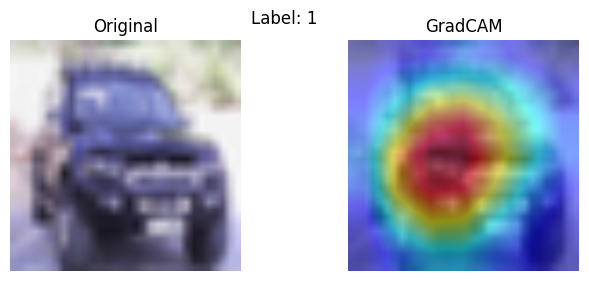

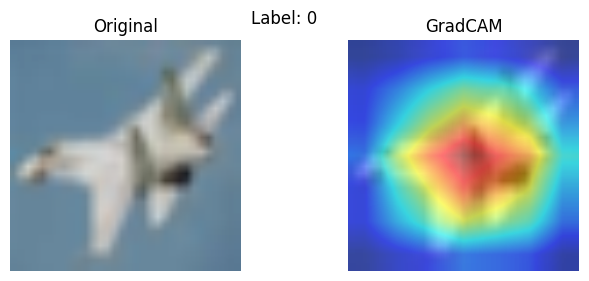

In [14]:
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt

# 1. Unwrap DataParallel if needed
model_for_xai = cifar_model.module if isinstance(cifar_model, torch.nn.DataParallel) else cifar_model
model_for_xai.eval()

# 2. Select 5 test images and their labels
dataiter = iter(cifar10_test_loader)
images, labels = next(dataiter)
images, labels = images[6:11], labels[6:11]
images = images.to(device)
labels = labels.to(device)

# 3. Prepare images for visualization (unnormalize to [0,1] for overlay)
def unnormalize(img_tensor):
    img = img_tensor.cpu().numpy().transpose(1,2,0)
    img = img * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
    return np.clip(img, 0, 1)

rgb_imgs = [unnormalize(images[i]) for i in range(5)]

# 4. Set up GradCAM
target_layers = [model_for_xai.layer4[-1]]
cam = GradCAM(model=model_for_xai, target_layers=target_layers)

# 5. Run GradCAM for each image
for i in range(5):
    input_tensor = images[i].unsqueeze(0)  # Shape: [1, 3, 224, 224]
    target = [ClassifierOutputTarget(labels[i].item())]
    grayscale_cam = cam(input_tensor=input_tensor, targets=target)[0]  # Shape: [224, 224]
    visualization = show_cam_on_image(rgb_imgs[i], grayscale_cam, use_rgb=True)
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.imshow(rgb_imgs[i])
    plt.title("Original")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(visualization)
    plt.title("GradCAM")
    plt.axis('off')
    plt.suptitle(f"Label: {labels[i].item()}")
    plt.show()
